# 04 Multiple Linear regression model trained on entire dataset 

> This is the regression model trained on the entire dataset and all covariates 

In [1]:
#|default_exp core.04_regression_model

In [2]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/03a_explore_datasets.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
import itertools

import scipy.stats as st

### Load the Autonomy style bits 

In [6]:
# Define the font path and style path
FONT_PATH = const.raw_data_path + '/JosefinSans-Regular.ttf'
STYLEPATH = const.raw_data_path + '/autonomy_white.mplstyle'

# Add the font to the font manager
fm.fontManager.addfont(FONT_PATH)

# Set the font family for matplotlib to use
plt.rcParams['font.family'] = 'Josefin Sans'
plt.style.use(STYLEPATH)

# Inform the user that the font was set
print("Josefin Sans font set for Matplotlib.")
print("mplstyle activated.")

Josefin Sans font set for Matplotlib.
mplstyle activated.


---

This model looks at automating the choice of parameters and the choice of training dataset using k-fold cross validation. 

In [7]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [8]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.054537,41.277676,29.459719,51.924546,16.393357,5.298762,2.534370,186.084815,0.105584
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.520773,57.864140,16.212434,51.872532,8.334167,2.933158,1.034842,437.450820,0.224167
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.757572,45.298420,19.513040,51.475795,11.160066,3.982729,1.633168,124.734713,0.107840
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.864371,46.247977,20.734161,51.097420,11.826167,4.774197,1.863024,442.084950,0.311082
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.658556,39.900936,24.100070,51.143136,13.049211,5.147664,1.839612,78.032656,0.093811


These are the covariates I'm interested in - each is calculated as a percentage of the total population of the region. 
* Age (% people over 65) `over_65_pc`
* Gender (% people female) `female_pc`
* Educational attainment (% people with A-level or higher education) `ALevel_plus_pc`
* Ethnicity (% people who are white British) `white_pc`
* Density of GPs (total number of GPs/ pop) `GP_LAD_pc`

Because they seem to have a large supressor effect we leave out the comorbidities: 
* Comorbidities (% people with various dementia comorbidities)
    - Hypertension `HYP_afflicted_pc`
    - Diabetes `DM_afflicted_pc`
    - Stroke `STIA_afflicted_pc`

In [9]:
#|export
# Potential covariates 
covar_opt = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc',
             'GP_LAD_pc']

This performs 5 fold cross-validation to determine the best combination of covariates. 

In [10]:
# Outcome data 
Y_data = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

# Parameters for cross validation 
n_folds = 5
cv_kfold = KFold(n_folds, random_state=13, shuffle=True)

# Model 
model = linear_model.LinearRegression()

covar_comb = {}
perform_by_covar = {}

key_num = 0
for i in range(1,9):
    for j, subset in enumerate(itertools.combinations(covar_opt, i)):
        covar_comb[key_num] = subset
        X_data = df_dem_plus[list(subset)].values.reshape(-1,i)
        # evaluate the model using 5-fold CV 
        scores = cross_val_score(model, X=X_data, y=Y_data, cv=cv_kfold)
        perform_by_covar[key_num] = np.mean(scores)
        key_num += 1
        #print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [11]:
# Best combination of covariates
covar_comb[max(perform_by_covar, key=perform_by_covar.get)]

('over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'GP_LAD_pc')

In [12]:
# Top 5 combination of covariates 
max_5 = sorted(perform_by_covar, key=perform_by_covar.get, reverse=True)[:5]
[f'Covariates:{covar_comb[x]}, Accuracy:{perform_by_covar[x]}' for x in max_5]

["Covariates:('over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'GP_LAD_pc'), Accuracy:0.7774724020040633",
 "Covariates:('over_65_pc', 'female_pc', 'white_pc', 'GP_LAD_pc'), Accuracy:0.7772609697200318",
 "Covariates:('over_65_pc', 'female_pc', 'white_pc'), Accuracy:0.7763463376336431",
 "Covariates:('over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc'), Accuracy:0.7760199702419159",
 "Covariates:('over_65_pc', 'female_pc', 'ALevel_plus_pc', 'GP_LAD_pc'), Accuracy:0.774196593609162"]

In [13]:
# Create dataframe of combinations of covariates
df_covar_comb = pd.DataFrame.from_dict(covar_comb, orient='index')
df_covar_comb.columns = ['covariate 1', 'covariate 2', 'covariate 3', 'covariate 4', 'covariate 5'
                         ]

# Create dataframe of accuracy
df_accuracy = pd.DataFrame.from_dict(perform_by_covar, orient='index')
df_accuracy.rename(columns={0:'accuracy (mean)'}, inplace=True)

# Merge 
df_model_acc = pd.merge(df_accuracy, df_covar_comb, left_index=True, right_index=True)

In [14]:
# This dataframe records the model accuracy for every combination of covariates 
df_model_acc

,accuracy (mean),covariate 1,covariate 2,covariate 3,covariate 4,covariate 5
0,0.769187,over_65_pc,None,None,None,None
1,-0.018927,female_pc,None,None,None,None
2,0.025560,ALevel_plus_pc,None,None,None,None
3,0.546197,white_pc,None,None,None,None
4,-0.040216,GP_LAD_pc,None,None,None,None
5,0.772450,over_65_pc,female_pc,None,None,None
6,0.768232,over_65_pc,ALevel_plus_pc,None,None,None
7,0.770476,over_65_pc,white_pc,None,None,None
8,0.770468,over_65_pc,GP_LAD_pc,None,None,None
9,0.046805,female_pc,ALevel_plus_pc,None,None,None


## Multiple Linear regression

In [15]:
print(covar_opt)

['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'GP_LAD_pc']


In [16]:
#|export
# Linear regression using sklearn 

x = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x, y)
y_pred = regr.predict(x)

In [17]:
print(regr.intercept_[0])

-1.1020440574909207


In [18]:
#|export
# save the regression coefficients so that I can use them in a different nb 

reg_coefficients = np.concatenate([regr.intercept_, regr.coef_[0]])
np.save(const.pre_output_path+'/reg_coeff.npy', reg_coefficients)

In [19]:
print("Regression estimates \n--------------\n--------------")
print(f'Intercept:{regr.intercept_[0]}')
print("--------------\nCoefficients of independent variables \n--------------")
for i, var in enumerate(covar_opt):
    print(f'{var}:{regr.coef_[0][i]} \n')

Regression estimates 
--------------
--------------
Intercept:-1.1020440574909207
--------------
Coefficients of independent variables 
--------------
over_65_pc:0.027200030320553504 

female_pc:0.02215972284843058 

ALevel_plus_pc:-0.0007202039605086789 

white_pc:0.0009109777506433679 

GP_LAD_pc:0.13830401298301845 



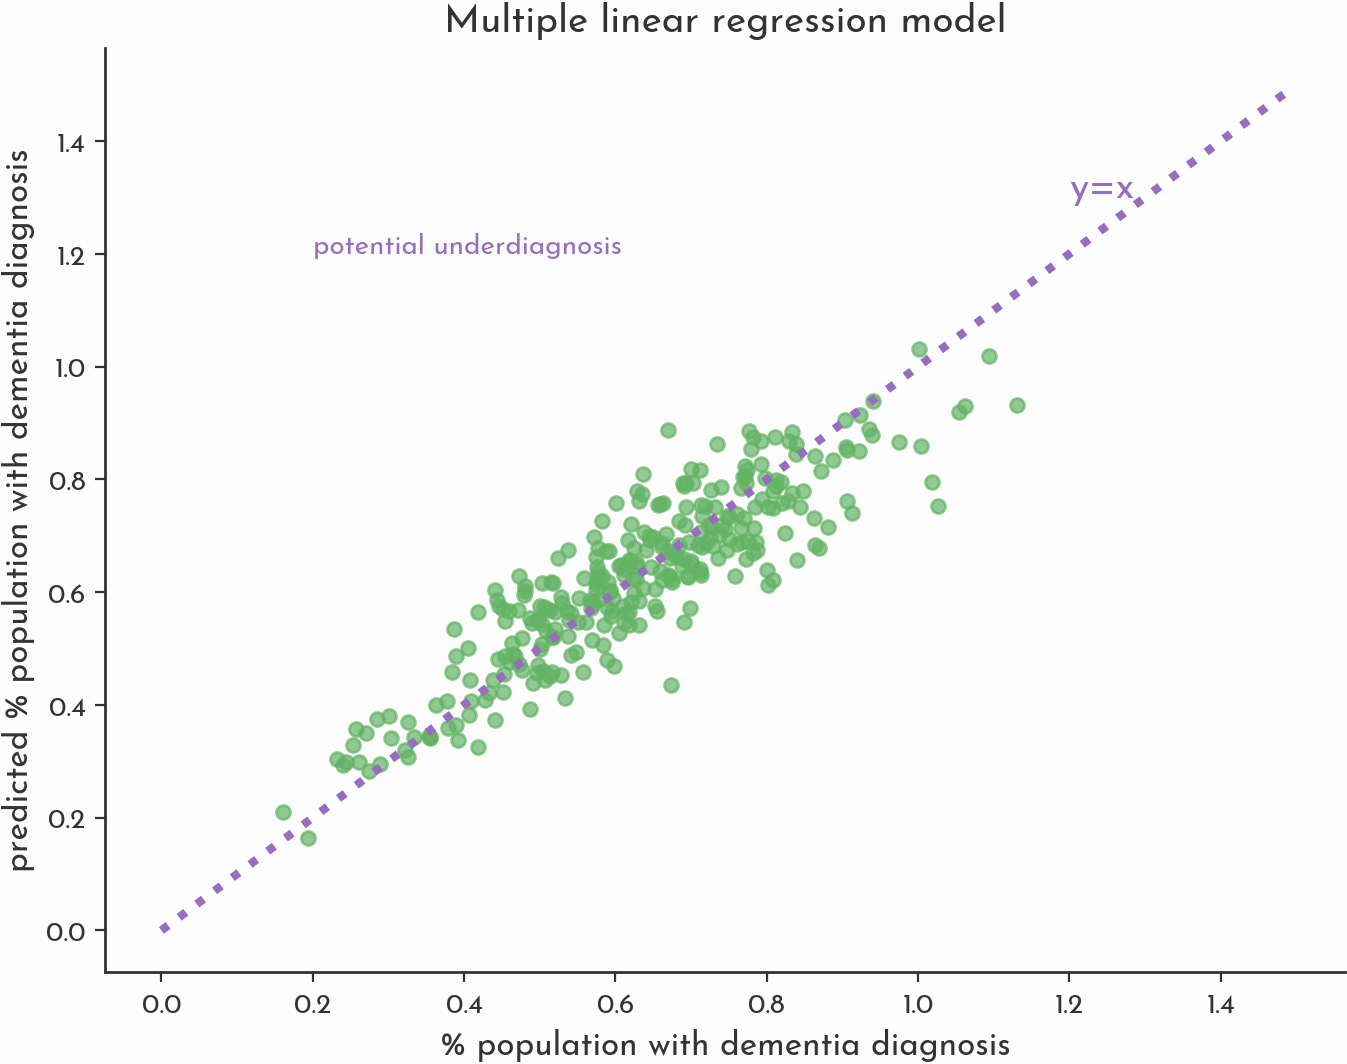

In [20]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.figure(figsize=(8,6), dpi=200)
plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='xkcd:deep lilac')
plt.scatter(y, y_pred, color='xkcd:boring green', alpha=0.7)
plt.xlabel('% population with dementia diagnosis', fontsize=12)
plt.ylabel('predicted % population with dementia diagnosis', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Multiple linear regression model', fontsize=14)
plt.text(1.2, 1.3, r'y=x', fontsize=14, color='xkcd:deep lilac')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10, color='xkcd:deep lilac')
plt.savefig(const.figs_path+'/linear_reg_scatter_plt.png')
plt.show()


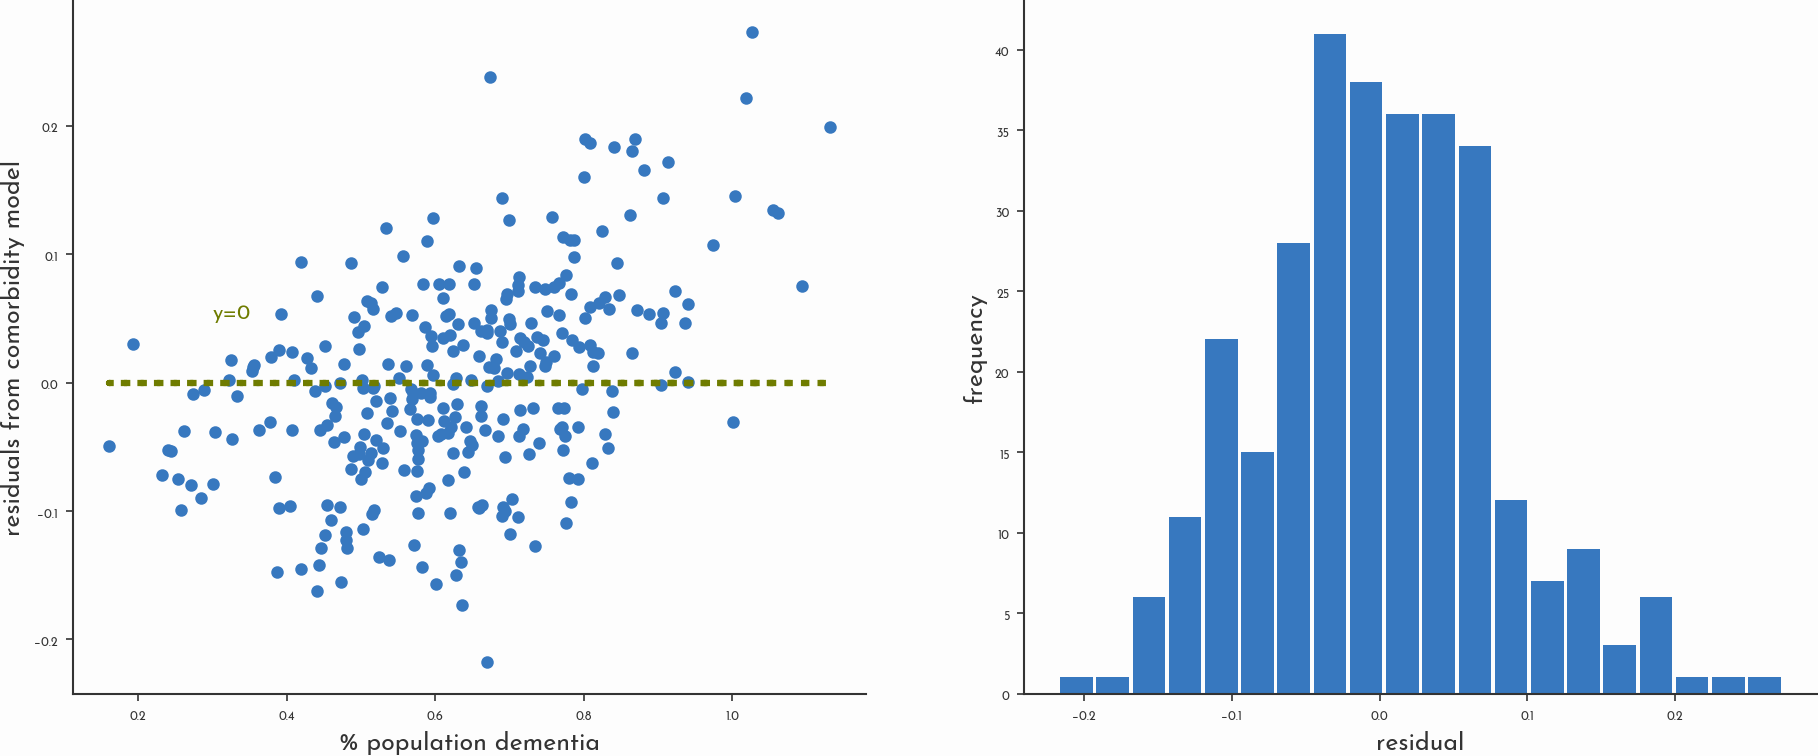

In [21]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

residuals = (y - y_pred).reshape(309)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y, residuals, color='xkcd:windows blue')
plt.plot(y, np.zeros(len(y)), ':', color='xkcd:poop green')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='xkcd:poop green')
plt.ylabel('residuals from comorbidity model', fontsize=12)
plt.xlabel('% population dementia', fontsize=12)

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, color='xkcd:windows blue', rwidth=0.9, bins=20)
plt.xlabel('residual', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.show()

### Save the results of the regression model to a .csv 

In [22]:
# add columns of results to the dataframe 
df_dem_plus['reg_model_residuals'] = residuals
df_dem_plus['reg_model_pred'] = y_pred

# save the dataframe 
df_dem_plus.to_csv(const.output_path+'/reg_model/reg_model_results.csv')

### And analyse the residuals 

In [23]:
# residuals 

# look at areas with gap between predicted diagnosis rate and observed diagnosis rate 
resid_gap_area = df_dem_plus[residuals<-0.15]['area_name']
print(resid_gap_area)
#[x for x in list(resid_gap_area)]

40               South Hams
55          Isles of Scilly
257    South Cambridgeshire
271                    Eden
274                  Thanet
288                Plymouth
Name: area_name, dtype: object


## Regularisation of regression 
### Ridge regression & Lasso regression

In [25]:
# Linear regression using sklearn and ridge regression
x = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr_ridge = linear_model.Ridge(alpha=1)

# fit regression comorbidities
regr_ridge.fit(x, y)
y_pred_ridge = regr_ridge.predict(x)


# Linear regression using sklearn and lasso 
x = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr_lasso = linear_model.Lasso(alpha=0.001)

# fit regression comorbidities
regr_lasso.fit(x, y)
y_pred_lasso = regr_lasso.predict(x)

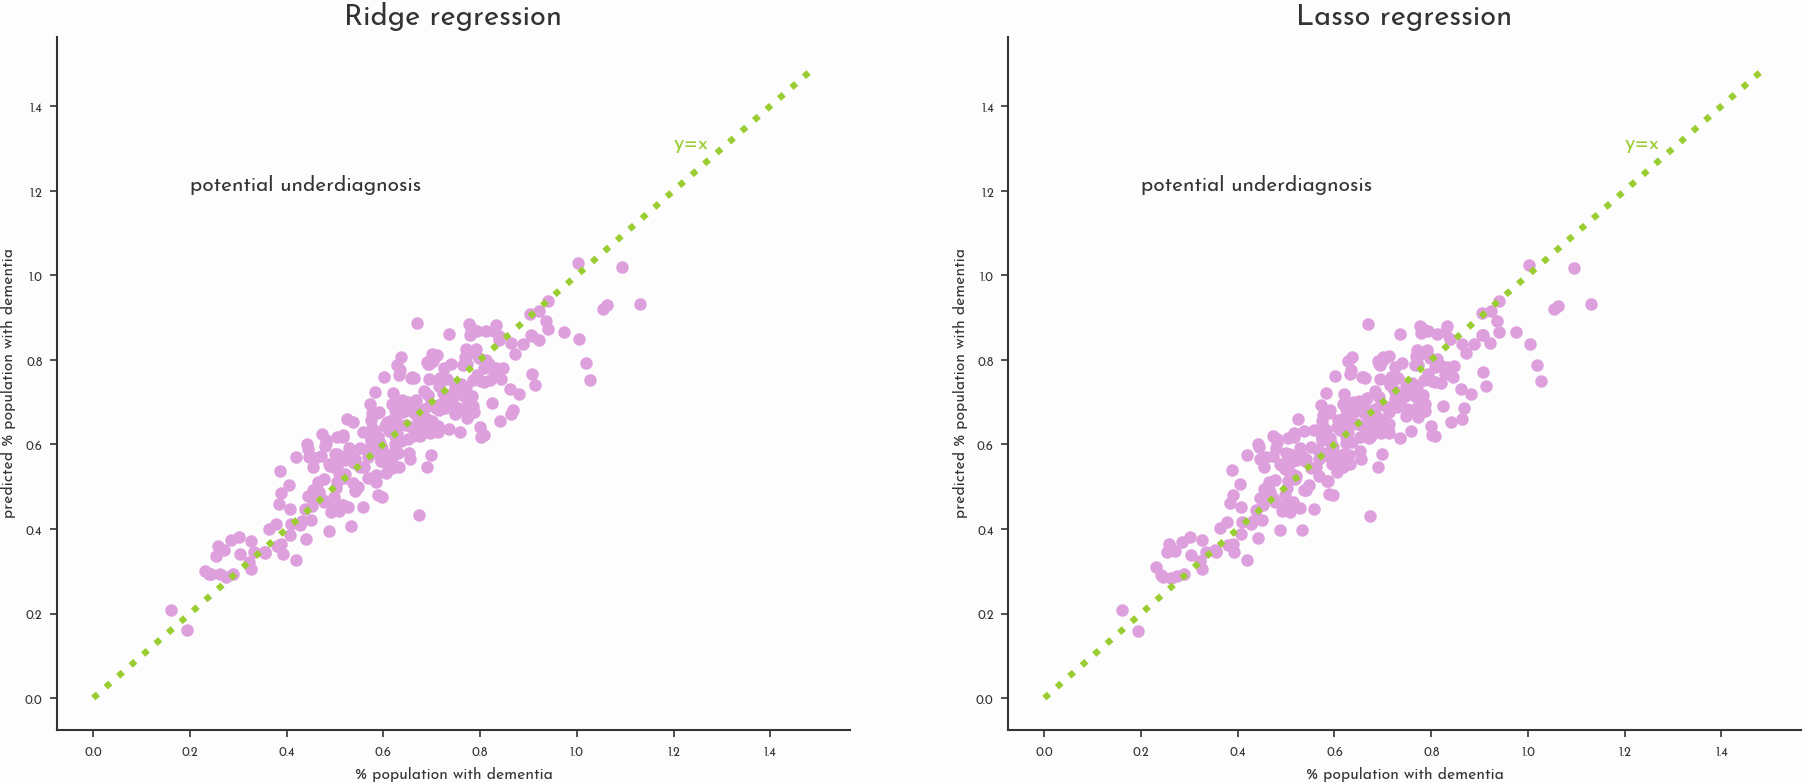

In [32]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

# ridge 
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y, y_pred_ridge, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Ridge regression', size=14)
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)

# lasso
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y, y_pred_lasso, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Lasso regression', size=14)
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)

plt.show()

In [27]:
print('Ridge regression \n -------- ')
print(f'intercept:{regr_ridge.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr_ridge.coef_[0][i]} \n')

Ridge regression 
 -------- 
intercept:-1.1040562213962994
-------- 
 coefficients of independent variables 
 
over_65_pc:0.02720182586036458 

female_pc:0.022249160565674934 

ALevel_plus_pc:-0.0005634093803146812 

white_pc:0.0009071626608575958 

GP_LAD_pc:0.06803315941874222 



In [31]:
print('Lasso regression \n -------- ')
print(f'intercept:{regr_lasso.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr_lasso.coef_[i]} \n')

Lasso regression 
 -------- 
intercept:-1.0116385851582752
-------- 
 coefficients of independent variables 
 
over_65_pc:0.02723672731997143 

female_pc:0.020454097499325294 

ALevel_plus_pc:-0.0003796387770979771 

white_pc:0.000899191447774931 

GP_LAD_pc:0.0 

